In [1]:
import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from cv2 import resize
from datetime import datetime
from gc import collect
from os import cpu_count
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm
from scipy.special import ellipk, ellipe


sys.path.append(f"{os.getcwd()}/working/")
sys.path.append(f"{os.getcwd()}/mltfm/")
from VisionTransformer_working import VisionTransformer as vit_old

2022-12-08 12:13:46.190415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 12:13:46.311525: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-08 12:13:46.678152: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/alexrichard/miniconda3/lib/
2022-12-08 12:13:46.678205: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.s

## Idea

Optimization for a linear combination of similar tasks often yields models that are more accurate, generalize better and require less training data. A possible multi-task objective for TFM could be
<h3><center>$\mathcal{L} = \alpha_{1}$$\cdot MSE + \alpha_{2}$$\cdot DTMA + \alpha_{3}$$\cdot DDA$</center></h3>
where
<h3><center>$\boldsymbol\alpha > 0, \space\space\sum_{i=1}^{3} \alpha_{i} = 1$</center></h3>


In [2]:
def cart2pol(x, y):
    rho = np.sqrt(x ** 2 + y ** 2)
    phi = np.arctan2(y, x)
    return (rho, phi)


def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return (x, y)


def inCircle(X, Y, x, y, r):
    return (X - x) ** 2 + (Y - y) ** 2 <= r ** 2

In [3]:
class EventGenerator:
    def __init__(self, params):
        self.params = params
        self.displacement_mesh = self.generate_mesh(0, 1, 0, 1, params['resolutionX'])
        self.force_mesh = self.generate_mesh(0, 1, 0, 1, params['resolutionY'])
        self.E = 1000
        self.f_res = 1 / (self.params['resolutionY'] - 1)

    def generate_mesh(self, left, right, front, back, resolution):
        X, Y = np.meshgrid(np.linspace(left, right, resolution), np.linspace(front, back, resolution))
        mesh = np.array([[(X[i][j], Y[i][j]) for j in range(len(X[i]))] for i in range(len(X))])
        return mesh

    def write_PointForces(self, PointForces):
        self.data_force.append(np.array([PointForces]))

    def write_Displacement(self, displacement):
        self.data_disp.append(np.array([displacement]))

    def min_dist(self, PF, point, R):
        return np.min(np.sqrt((PF.x_coord - point[0]) ** 2 + (PF.y_coord - point[1]) ** 2) - 2 * R)

    def generate_PointForces(self):
        num_i = self.params['resolutionY']
        counter = 0
        PointForcemesh = np.zeros((self.params['resolutionY'], self.params['resolutionY'], 2))
        PointForces = pd.DataFrame({"x_coord": [], "y_coord": [], "force": [], "gamma": [], "radius": []})
        while counter < np.random.uniform(10, 50):
            R = np.random.uniform(0.01, 0.05)
            point = np.random.uniform(0 + R + 0.05, 1 - R - 0.05, 2)
            force = np.random.uniform(self.params['traction_min'], self.params['traction_max'])
            force = force / self.E
            gamma = np.random.uniform(0, 2 * np.pi)
            if counter == 0 or self.min_dist(PointForces, point, R) > 0.001:
                PointForces = PointForces.append({"x_coord": point[0],
                                                  "y_coord": point[1],
                                                  "force": force,
                                                  "gamma": gamma,
                                                  "radius": R},
                                                 ignore_index=True)
                x_f, y_f = pol2cart(force, gamma)
                PointForcemesh[
                    inCircle(self.force_mesh[:, :, 0], self.force_mesh[:, :, 1], point[0], point[1], R)] += np.array(
                    [x_f, y_f])
                counter += 1

        return PointForcemesh, PointForces
    
    def generate_displacement(self, PointForces):
        raise NotImplementedError
    
    def generate(self, event_num):
        #f_data_disp = tables.open_file('../ViT-TFM/data/displacements_50.h5', mode='w')
        #atom = tables.Float64Atom()
        self.data_disp = np.zeros((0, self.params['resolutionX'], self.params['resolutionX'], 2))
        #f_data_force = tables.open_file('../ViT-TFM/data/tractions_50.h5', mode='w')
        self.data_force = np.zeros((0, self.params['resolutionX'], self.params['resolutionX'], 2))

        PointForcesmesh, PointForces = self.generate_PointForces()
        displacement, displacements = self.generate_displacement(PointForces)
        
        return displacement, displacements, PointForces, PointForcesmesh

In [4]:
class AnalyticalEventGenerator(EventGenerator):

    def analytical(self, point, traction, R):
        p0 = traction[0]
        gamma = traction[1]
        r, theta = cart2pol(point[0], point[1])
        if r < R:
            if r < 1e-4:
                N1 = 2 * np.pi
                N2 = np.pi
                N3 = 0
                N4 = np.pi
            zeta1 = r ** 2 / R ** 2
            E0 = ellipe(zeta1)
            K0 = ellipk(zeta1)
            N1 = 4 * E0
            N2 = (4 * np.cos(2 * theta) * ((r ** 2 + R ** 2) * E0 + (r ** 2 - R ** 2) * K0)) / (
                        3 * r ** 2) + 4 * np.sin(theta) ** 2 * E0
            N3 = (2 * np.sin(2 * theta) * ((r ** 2 - 2 * R ** 2) * E0 + 2 * (R ** 2 - r ** 2) * K0)) / (3 * r ** 2)
            N4 = 4 * np.cos(theta) ** 2 * E0 - (
                        4 * np.cos(2 * theta) * ((r ** 2 + R ** 2) * E0 + (r ** 2 - R ** 2) * K0)) / (3 * r ** 2)
        else:
            zeta2 = R ** 2 / r ** 2
            E0 = ellipe(zeta2)
            K0 = ellipk(zeta2)
            N1 = (4 * (r ** 2 * E0 + (R ** 2 - r ** 2) * K0)) / (r * R)
            N2 = ((6 * r ** 2 - 2 * (r ** 2 - 2 * R ** 2) * np.cos(2 * theta)) * E0 + 2 * (r ** 2 - R ** 2) * (
                        np.cos(2 * theta) - 3) * K0) / (3 * r * R)
            N3 = (2 * np.sin(2 * theta) * ((r ** 2 - 2 * R ** 2) * E0 + (R ** 2 - r ** 2) * K0)) / (3 * r * R)
            N4 = ((6 * r ** 2 + 2 * (r ** 2 - 2 * R ** 2) * np.cos(2 * theta)) * E0 - 2 * (r ** 2 - R ** 2) * (
                        np.cos(2 * theta) + 3) * K0) / (3 * r * R)
        ux = R * (1 + self.params['nu']) / (np.pi) * (
                    ((1 - self.params['nu']) * N1 + self.params['nu'] * N2) * p0 * np.cos(gamma) - self.params[
                'nu'] * N3 * p0 * np.sin(gamma))
        uy = R * (1 + self.params['nu']) / (np.pi) * (-self.params['nu'] * N3 * p0 * np.cos(gamma) + (
                    (1 - self.params['nu']) * N1 + self.params['nu'] * N4) * p0 * np.sin(gamma))
        
        return ux, uy
    
    def generate_displacement(self, PointForces):
        displacement = np.zeros((len(self.displacement_mesh), len(self.displacement_mesh[0]), 2))
        displacements = []
        for index, row in PointForces.iterrows():
            print(f"Index {index}")
            trafo = np.array([-row.x_coord, -row.y_coord])
            print(f"trafo is {trafo}")
            force = np.array([row.force, row.gamma])
            print(f"force is {force}")
            new_cell = np.array([[self.analytical(self.displacement_mesh[i][j] + trafo, force, row.radius)
                                       if self.analytical(self.displacement_mesh[i][j] + trafo, force,
                                                          row.radius) is not np.nan
                                       else self.analytical(
                self.displacement_mesh[i][(j - 1) % len(self.displacement_mesh[i])] + trafo, force, row.radius)
                                       for j in range(len(self.displacement_mesh[i]))
                                       ]
                                      for i in range(len(self.displacement_mesh))
                      ])
            displacements.append(new_cell)
            displacement += new_cell

        return displacement, displacements

In [5]:
Gen = AnalyticalEventGenerator({'resolutionX': 104,
                                'resolutionY': 104,
                                'traction_min': 0,
                                'traction_max': 500,
                                'nu': 0.49})

In [6]:
displacement, displacements, PointForces, PointForcemesh = Gen.generate(1)

/tmp/ipykernel_2083323/3215104302.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PointForces = PointForces.append({"x_coord": point[0],
/tmp/ipykernel_2083323/3215104302.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PointForces = PointForces.append({"x_coord": point[0],
/tmp/ipykernel_2083323/3215104302.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PointForces = PointForces.append({"x_coord": point[0],
/tmp/ipykernel_2083323/3215104302.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PointForces = PointForces.append({"x_coord": point[0],
/tmp/ipykernel_2083323/3215104302.py:35: FutureWarning: The frame.append met

Index 0
trafo is [-0.36697971 -0.88939512]
force is [0.47853992 2.0656277 ]
Index 1
trafo is [-0.23062214 -0.48287433]
force is [0.30102362 3.94380411]
Index 2
trafo is [-0.74605977 -0.68321128]
force is [0.13991999 3.72578725]
Index 3
trafo is [-0.92926464 -0.5603495 ]
force is [0.31037742 4.14662024]
Index 4
trafo is [-0.5247493 -0.434572 ]
force is [0.14149199 5.98174504]
Index 5
trafo is [-0.30640467 -0.19459726]
force is [0.28742282 1.88316185]
Index 6
trafo is [-0.61570077 -0.16271057]
force is [0.25449789 0.22107277]
Index 7
trafo is [-0.14370514 -0.37644524]
force is [0.39419479 0.5257377 ]
Index 8
trafo is [-0.62440845 -0.70314357]
force is [0.14970577 3.90050818]
Index 9
trafo is [-0.43241861 -0.54153692]
force is [0.36369193 1.91705584]
Index 10
trafo is [-0.74178763 -0.86508612]
force is [0.34472185 4.30582797]
Index 11
trafo is [-0.8502731  -0.66921214]
force is [0.26460972 1.20623641]
Index 12
trafo is [-0.06236909 -0.92511082]
force is [0.21242204 1.17158534]
Index 13
tr

In [7]:
dspls = displacements

In [8]:
displacement.shape

(104, 104, 2)

In [9]:
len(dspls)

14

In [10]:
PointForces

,x_coord,y_coord,force,gamma,radius
0,0.366980,0.889395,0.478540,2.065628,0.011145
1,0.230622,0.482874,0.301024,3.943804,0.023082
2,0.746060,0.683211,0.139920,3.725787,0.027930
3,0.929265,0.560349,0.310377,4.146620,0.015091
4,0.524749,0.434572,0.141492,5.981745,0.047304
5,0.306405,0.194597,0.287423,1.883162,0.021193
6,0.615701,0.162711,0.254498,0.221073,0.021350
7,0.143705,0.376445,0.394195,0.525738,0.019649
8,0.624408,0.703144,0.149706,3.900508,0.041070
9,0.432419,0.541537,0.363692,1.917056,0.047577


In [41]:
np.array_equal(dspls[0], dspls[1])

False

<IPython.core.display.Javascript object>


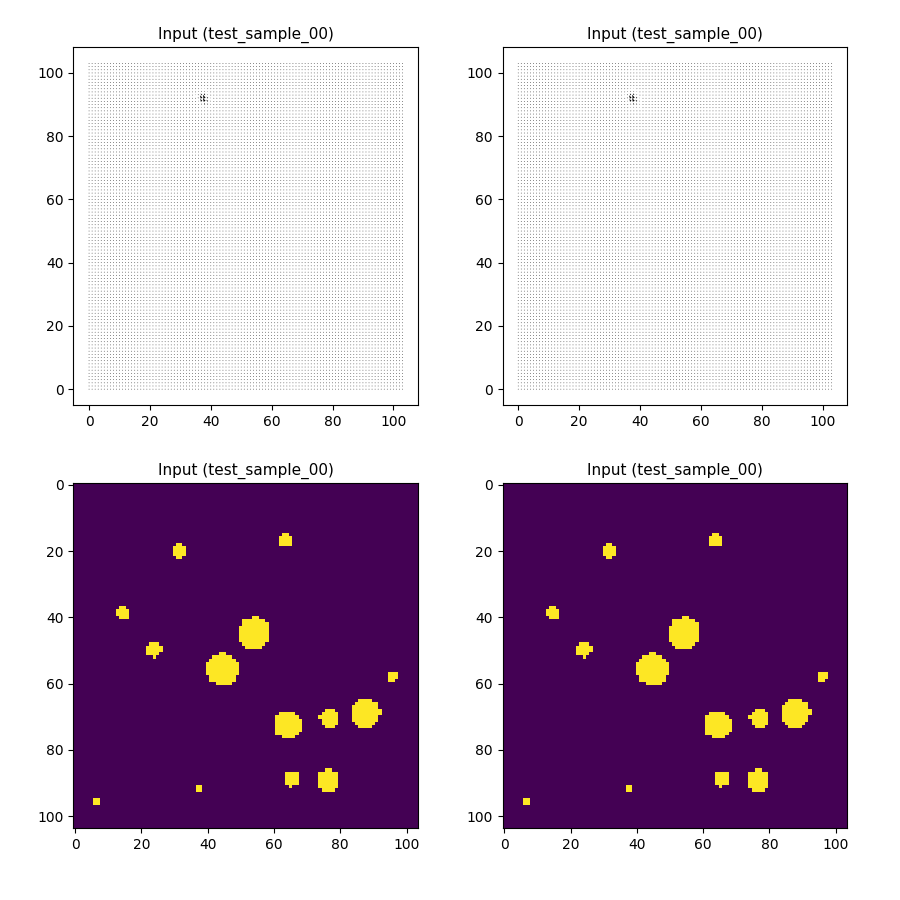

Text(0.5, 1.0, 'Input (test_sample_00)')

In [49]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(2,2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0, 0].quiver(dspls[0][:,:,0], dspls[0][:,:,1], scale=1)
axs[0, 0].set_title('Input (test_sample_00)', {'fontsize': 11})

axs[0, 1].quiver(dspls[0][:,:,0], dspls[0][:,:,1], scale=1)
axs[0, 1].set_title('Input (test_sample_00)', {'fontsize': 11})

binary = binary_mask[:,:,0] > 0
axs[1, 0].imshow(binary)
axs[1, 0].set_title('Input (test_sample_00)', {'fontsize': 11})

binary = binary_mask[:,:,1] > 0
axs[1, 1].imshow(binary)
axs[1, 1].set_title('Input (test_sample_00)', {'fontsize': 11})

In [43]:
binary_mask = np.where(PointForcemesh != 0, 1, 0)

In [44]:
binary_mask.shape

(104, 104, 2)

In [45]:
np.array_equal(binary_mask[:,:,0],binary_mask[:,:,1]) 

True

In [46]:
binary = binary_mask[:,:,0] > 0
plt.imshow(binary)
plt.show()

In [47]:
binary = binary_mask[:,:,1] > 0
plt.imshow(binary)
plt.show()